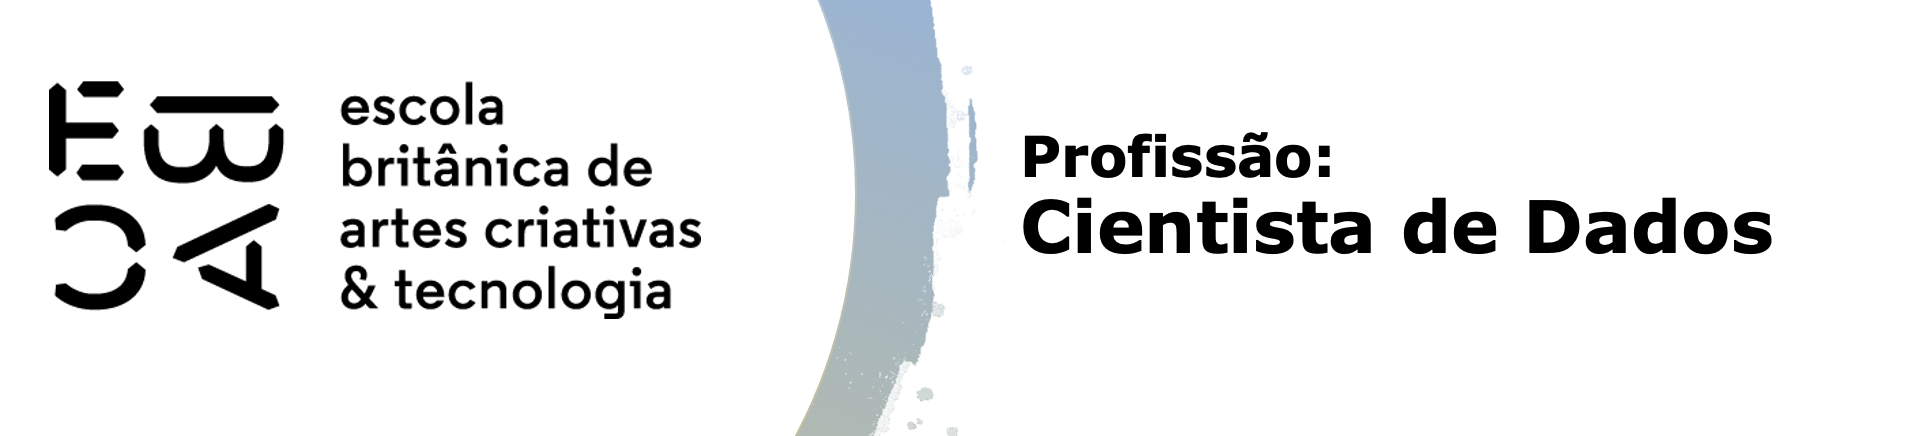
# Módulo 23 - Combinação de Modelos I

# Tarefa 02


### 1. Monte um passo a passo para o algoritmo RF

O passo-a-passo pode ser divido em três partes, sendo elas:

#### 1.1 _Bootstrap + Feature Selection_

É carregado o dataframe na qual se deseja realizar a predição de dados. Ele é submetido à amostragem por reposição (conhecida por _bootstrap_) que é a seleção aleatória de linhas do dataframe, podendo ser repetidas; e ao _Feature Selection_, que é a seleção aleatória de colunas do mesmo. A quantidade _default_ de colunas escolhidas varia de acordo com o tipo de dado presente na variável _target_. Sendo _p_ o total de colunas no dataframe e _m_, a quantidade de colunas escolhidas, temos:

- Para o tipo _Classifier_:

$$ m = \sqrt{p} $$

- Para o tipo _Regression_:

$$ m = \frac{p}{3} $$

O número de dataframes criados por estas técnicas é definido pelo usuário.

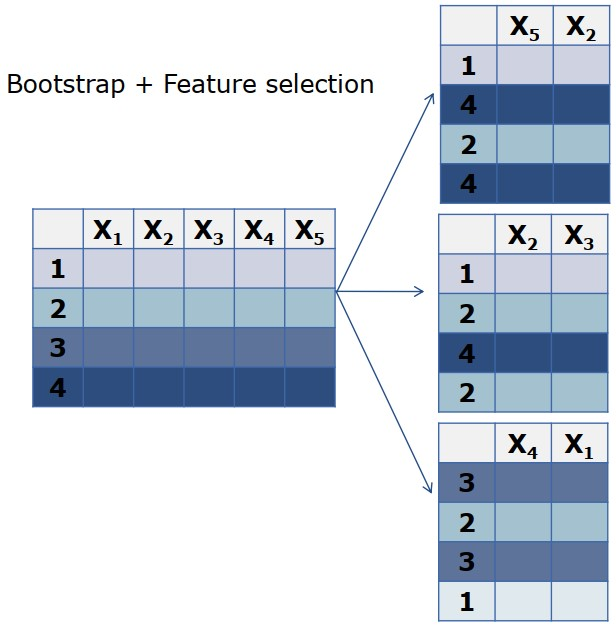

#### 1.2 _Base Learners_

Também chamada de treinamento simultâneo. Nesta etapa, cada um dos novos dataframes é submetido independentemente à uma modelagem de Árvore de Decisão. Se a variável resposta for do tipo _classifier_, são usadas Árvores de Classificação; no caso da _target_ ser numérica (ou _Regression_), são usadas Árvores de Regressão.

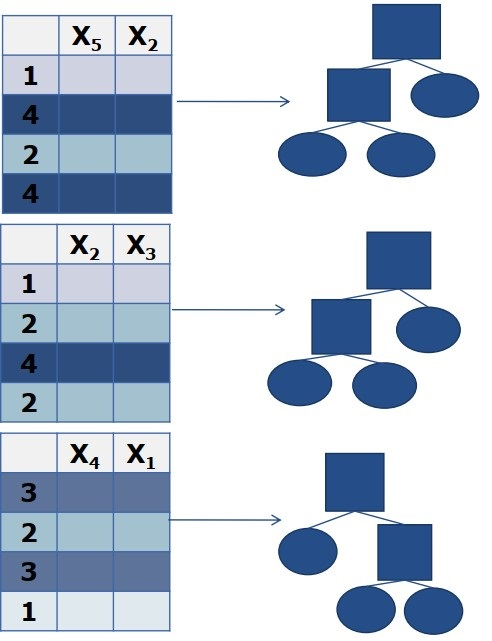

#### 1.3 _Aggregating_

Após as modelagens das árvores, são submetidas linhas de testes a elas. Os resultados de todas elas são coletados e agregados, definindo o valor final predito de cada linha analisada. Tal como nas etapas anteriores, a agregação depende do tipo de dado analisado. No caso de classificações, são contadas as classes obtidas para cada linha pela _Base Learner_ e aquela com maior frequência é considerada a classe resultante da predição (método conhecido por _Majority Vote_). Por outro lado, se os dados forem numéricos (ou seja, uma regressão), o valor final de cada linha será a média dos obtidos nos modelos.

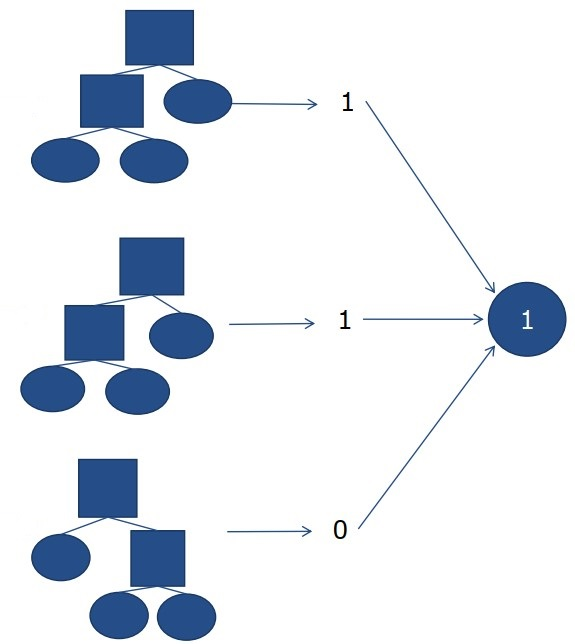

### 2. Explique com suas palavras o Random forest


_Random Forest_ é uma técnica de predição semelhante ao _Bagging_ na qual são utilizados modelos de árvores sobre conjuntos de dados derivados do dataframe inicial na qual se deseja analisar. Esta técnica é composta de três etapas, sendo elas:

1. Bootstrap + Feature Selection, onde são criados vários dataframes com linhas e colunas aleatórias do conjunto de dados inicial;

2. Base Learners, onde são aplicados modelos de Árvores de Decisão sobre os dataframes gerados;

3. Aggregating, que é a submissão de uma linha ou conjunto de dados de teste sobre a Base Leaners. Para cada linha analisada são agregados os valores preditos a ela pelas modelagens, e o resultado é aquele com maior frequência ou a média de todos os obtidos (muda de acordo com o tipo de dado na variável resposta em questão).

Esta técnica é muito útil na redução do risco de erros na predição e overfitting do ajuste das árvores.

### 3. Qual a diferença entre Bagging e Random Forest?

Na comparação entre o Bagging e o Random Forest são notadas duas diferenças principais:

- Enquanto que no _Bagging_ há apenas a seleção de linhas aleatórias do dataframe (_Bootstrap_), no _Random Forest_ também há a seleção aleatória de colunas do dataframe (_Feature Selection_), cuja quantidade padrão de colunas selecionadas varia de acordo com o tipo de dado presente na variável resposta;


- No Random Forest, a etapa _Base Learners_ é formada apenas por Árvores de Decisão, enquanto que no _Bagging_ podem ser usados tanto modelos de Árvores de Decisão quanto os de Regressão.  

### 4. (Opcional) Implementar em python o Random Forest
– Bootstrap

– Feature selection

– Modelagem com Decision trees

– Agregação

#### 4.1 Pacotes necessários
Os pacotes utilizados nesta tarefa são:
- os, para a criação de pastas para salvar os modelos;
- pandas, para leitura e interação com os dados;
- numpy, para operações matemáticas não comum no python;
- sklearns.datasets, na qual vão ser usados os comandos load_wine (dataset classification) e load_diabetes (dataset regression);
- sklearn.model_selection, com o comando train_test_split, para dividir cada dataframe em treino e teste;
- sklearn.tree para aplicar os modelos DecisionTreeClassifier e DecisionTreeRegressor nos dataframes;
- sklearn.metrics, com os comandos accuracy_socre e r2_score, para avaliar os ajustes das árvores nos dataframes.

In [1]:
import os

import pandas as pd
import numpy as np

from sklearn.datasets import load_wine
from sklearn.datasets import load_diabetes

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

#### 4.2 Função Random Forest em Classifiers

Para o caso dos dados analisados serem do tipo classifier, vamos definir uma função que aplique a técnica _Random Forest_ sobre eles. O nome da função será rf_classifier. Nesta função, será criada uma _Base Learners_ cujo comprimento é definido pelo parâmetro _n_. Será aplicado o modelo de árvores de classificação em cada conjunto de dados desta base.

In [41]:
def rf_classifier(df: pd.DataFrame, n: int=3,
                       m: int=0,
                       base_teste: float=0.3) -> pd.DataFrame:
    '''
    Função para predizer as classes de um dataframe a partir da técnica 
    de ensemble Bagging. Para isso, ela recebe 3 parâmetros:
    
    df -> dataframe que se quer analisar, a variável resposta deve ser do 
    tipo classifier;
    
    n -> número de amostras criadas por bootstrap (amostragem por reposição)
    do df. Cada uma delas é salva no formato csv em uma pasta criada nessa função.
    O valor default é de 3 amostras.
    
    m -> Número de colunas do df selecionadas aleatóriamente, sendo por padrão
    a parte inteira da raíz do número de colunas no df. 
    
    base_teste -> Porcentagem do df que será usada como teste. O restante é usada 
    como treinamento. O valor default é de 30%.
    
    Em cada amostra criada, é aplicado o modelo de DecisionTreeClassifier, salvando
    os valores preditos do target em um dicionário.
    
    No fim, é retornado a tabela desenvolvida com os valores originais do target
    e os preditos pelas árvores de classificação aplicadas em cada amostra de 
    bootstrap, além da acurácia do ajuste final.
    '''
    
    # Divisão do dataframe em treino e teste
    treino, teste = train_test_split(df, test_size=base_teste)
    
    # Base de teste
    X_teste = teste.drop(['target'], axis=1)
    y_teste = teste['target'].rename('y_teste')
    
    # Número total de colunas na tabela:
    cols = X_teste.shape[1]
    
    # Número de colunas selecionadas pelo Feature Selection
    if m <= 0 or m > cols:
        m = round(np.sqrt(cols))
    
    # Dicionário para guardar os valores preditos pelos modelos no bagging
    y_bagging = {}
    
    # Número de linhas na base de treino
    len_treino = len(treino)
    
    # Verifica se há uma pasta para salvar os modelos, se não, cria uma
    if not os.path.exists('./Classifier Models'):
        os.mkdir('./Classifier Models')
    
    # Looping para gerar as amostras por bootstrap e modelá-las.
    for i in range(n):
        
        # Bootstrap
        treino_i = treino.sample(n=len_treino, axis=0, replace=True)
        
        # Feature Selection
        X_treino = treino_i.drop(['target'], axis=1)
        X_treino = X_treino.sample(n=m, axis=1)
        
        # Variável resposta do treino
        y_treino = treino_i['target']
        
        # Nome do arquivo csv com a amostra de bootstrap, salvando-a na pasta criada
        nome = './Classifier Models/modelo_' + str(i) + '.csv'
        
        # Salva a amostra de bootstrap em csv
        X_treino.to_csv(nome)
        
        # Modelagem - Base Learners
        modelo = DecisionTreeClassifier(random_state=42)
        modelo.fit(X_treino, y_treino)
        
        # Salva as predições do fit no dicionário para a etapa Aggregating
        y_bagging.update({i: modelo.predict(X_teste[X_treino.columns])})
        
    # Aggregating, agregando o valor mais frequente de cada predição
    y_pred = pd.DataFrame(y_bagging).mode(axis=1).rename(columns={0: 'y_pred'})
    
    
    # Cálculo da acurácia do ajuste
    acuracia = accuracy_score(y_true=y_teste, y_pred=y_pred['y_pred'])
    
    # Resultados
    print('Modelo: Árvore de Decisão')
    print(f'Acurácia do ajuste: {acuracia:.2f}')
    
    # Tabela com a comparação dos valores verdadeiros com os preditos de y
    tb_final = pd.concat(objs=[y_teste.reset_index(drop=True),
                               y_pred['y_pred']], axis=1)
    
    # Retorna a tabela com os dados verdadeiros e preditos
    return tb_final

Para demonstrar a função criada, vamos aplicá-la sobre o dataset load_wine do sklearn e medir a acurácia do ajuste.

In [42]:
# Salva os variáveis explicativas do dataset load_wine() em um dataframe
df = pd.DataFrame(load_wine().data, columns=load_wine().feature_names)

# Adiciona uma coluna ao dataframe, contendo os valores da variável resposta
df['target'] = load_wine().target

# Submete o df à função desenvolvida, criando 7 amostras bootstraps
df_final = rf_classifier(df=df, n=7, m=0, base_teste=0.3)

# Mostra as 5 primeiras linhas da tabela comparativa dos y
df_final.head()

Modelo: Árvore de Decisão
Acurácia do ajuste: 0.98


,y_teste,y_pred
0,2,2.0
1,2,2.0
2,2,2.0
3,1,1.0
4,0,0.0


#### 4.3 Função Bagging em Regression

Para o caso dos dados analisados serem do tipo regression, vamos definir uma função que aplique a técnica _Random Forest_ sobre eles. O nome da função será rf_regressor. Nesta função, será criada uma _Base Learners_ cujo comprimento é definido pelo parâmetro _n_. Será aplicado o modelo de árvores de regressão em cada conjunto de dados desta base.

In [43]:
def rf_regressor(df: pd.DataFrame, n: int=3,
                      m: int=0,
                      base_teste: float=0.3) -> pd.DataFrame:
    '''
    Função para predizer as classes de um dataframe a partir da técnica 
    de ensemble Bagging. Para isso, ela recebe 3 parâmetros:
    
    df -> dataframe que se quer analisar, a variável resposta deve ser do 
    tipo regression;
    
    n -> número de amostras criadas por bootstrap (amostragem por reposição)
    do df. Cada uma delas é salva no formato csv em uma pasta criada nessa função.
    O valor default é de 3 amostras.
    
    m -> Número de colunas do df selecionadas aleatóriamente, sendo por padrão
    a parte inteira de um terço do número de colunas no df. 
    
    base_teste -> Porcentagem do df que será usada como teste. O restante é usada 
    como treinamento. O valor default é de 30%.
    
    Em cada amostra criada, é aplicado o modelo de DecisionTreeRegressor, salvando
    os valores preditos do target em um dicionário.
    
    No fim, é retornado a tabela desenvolvida com os valores originais do target
    e os preditos pelas árvores de regressão aplicadas em cada amostra de 
    bootstrap, além do r-quadrado do ajuste final.
    '''
    
    # Divisão do dataframe em treino e teste
    treino, teste = train_test_split(df, test_size=base_teste)
    
    # Base de teste
    X_teste = teste.drop(['target'], axis=1)
    y_teste = teste['target'].rename('y_teste')
    
    # Número total de colunas na tabela:
    cols = X_teste.shape[1]
    
    # Número de colunas selecionadas pelo Feature Selection
    if m <= 0 or m > cols:
        m = round(cols/3)
    
    # Dicionário para guardar os valores preditos pelos modelos no bagging
    y_bagging = {}
    
    # Número de linhas na base de treino
    len_treino = len(treino)
    
    # Verifica se há uma pasta para salvar os modelos, se não, cria uma
    if not os.path.exists('./Regressor Models'):
        os.mkdir('./Regressor Models')
    
    # Looping para gerar as amostras por bootstrap e modelá-las.
    for i in range(n):
        
        # Bootstrap
        treino_i = treino.sample(n=len_treino, replace=True)
        
        # Feature Selection
        X_treino = treino_i.drop(['target'], axis=1)
        X_treino = X_treino.sample(n=m, axis=1)
        
        # Variável resposta do treino
        y_treino = treino_i['target']
        
        # Nome do arquivo csv com a amostra de bootstrap, salvando-a na pasta criada
        nome = './Regressor Models/modelo_' + str(i) + '.csv'
        
        # Salva a amostra de bootstrap em csv
        X_treino.to_csv(nome)
        
        # Modelagem - Base Learners
        modelo = DecisionTreeRegressor(random_state=42)
        modelo.fit(X_treino, y_treino)
        
        # Salva as predições do fit no dicionário para a etapa Aggregating
        y_bagging.update({i: modelo.predict(X_teste[X_treino.columns])})
        
    # Aggregating, agregando o valor médio de cada predição
    y_pred = pd.DataFrame(y_bagging).mean(axis=1).rename('y_pred')
    
    
    # Cálculo do r-quadrado do ajuste
    r2 = r2_score(y_true=y_teste, y_pred=y_pred)
    
    # Resultados
    print('Modelo: Árvore de Regressão')
    print(f'R-quadrado do ajuste: {r2:.2f}')
    
    # Tabela com a comparação dos valores verdadeiros com os preditos de y
    tb_final = pd.concat(objs=[y_teste.reset_index(drop=True),
                               y_pred], axis=1)
    
    # Retorna a tabela com os dados verdadeiros e preditos
    return tb_final

Para demonstrar a função criada, vamos aplicá-la sobre o dataset load_diabetes do sklearn e medir o R-quadrado do ajuste.

In [44]:
# Salva os variáveis explicativas do dataset load_wine() em um dataframe
df = pd.DataFrame(load_diabetes().data, columns=load_diabetes().feature_names)

# Adiciona uma coluna ao dataframe, contendo os valores da variável resposta
df['target'] = load_diabetes().target

# Submete o df à função desenvolvida, criando 7 amostras bootstraps
df_final = rf_regressor(df=df, n=7, base_teste=0.3)

# Mostra as 5 primeiras linhas da tabela comparativa dos y
df_final.head()

Modelo: Árvore de Regressão
R-quadrado do ajuste: 0.24


,y_teste,y_pred
0,84.0,92.428571
1,245.0,178.535714
2,272.0,162.142857
3,96.0,116.785714
4,116.0,154.000000
